# Prediction of Bike Sharing Demand 
##### *(Matthew Holmes, Andrew Kabatznick, Grant Whittington)*
## Problem Description

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

We are provided with hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Hourly rental data spanning two years has been provided. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set.  

**Data Fields Provided**

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** -  
  1: Clear, Few clouds, Partly cloudy, Partly cloudy  
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals

[Kaggel Competition Overview](https://www.kaggle.com/c/bike-sharing-demand)   
[Kaggel Competition Data](https://www.kaggle.com/c/bike-sharing-demand/data)

## Libraries

In [1]:
#Libraries needed for analysis 
%matplotlib inline

#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#sklearn libraries
from sklearn.cross_validation import cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import make_scorer

#supress warngings in some cases
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/nic0lek/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nic0lek/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Baseline Data Analysis

The data is loaded and viewed below for the train and test dataset.  From the train dataset we can see that casual, registered, and count are our dependent variables.  The shapes of the data and the features are also shown below.

In [2]:
#Loading and Viewing the data
df_train = pd.read_csv('train.csv', parse_dates=[0], index_col=0)
print 'Training Data:'
print df_train.head()
print 
df_test = pd.read_csv('test.csv', parse_dates=[0], index_col=0)
print 'Test Data:'
print df_test.head()
print
print 'Shape of training data:'
print df_train.shape
print 
print 'Shape of test data'
print df_test.shape
print 
features = df_train.columns.values[:-3]
print 'Training data features:'
print features

Training Data:
                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40  
2011-01-01 02:00:00        80        0.0       5          27     32  
2011-01-01 03:00:00        75        0.0       3          10     13  
2011-01-01 04:00:00        75        0.

### Baseline
The preferred Kaggle evaluation criteria is RMSLE as defined by the competition. First we start by prediction the outcome variable with its median set the baseline. We will use a 10-fold cross validation, to balance between training a good model with low bias and having sufficient test examples to check accuracy.  Our RMSLE is comparable to the Kaggle submission score, so we will use the RMSLE as a standard for model accuracy.  

In [3]:
#Kaggle Evaluation Criteria: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

In [4]:
#Baseline prediction using a median model
base_median_model = DummyRegressor(strategy="median")
base_median_preds = cross_val_predict(base_median_model, df_train[features], df_train['count'], cv=10)

kaggle_fit_base_median = base_median_model.fit(df_train[features], df_train['count'])
kaggle_predict_base_median = base_median_model.predict(df_test[features])

base_median_RMSLE = RMSLE(df_train['count'], base_median_preds)
base_median_R2 = metrics.r2_score(df_train['count'], base_median_preds)

print 'Baseline median RMSLE: ', base_median_RMSLE
print 'Baseline median R2: ', base_median_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_predict_base_median}, columns = ["datetime", "count"])
df_submission.to_csv('base_median_bike_sharing_prediction_output.csv', index=False)

Baseline median RMSLE:  1.4895164464
Baseline median R2:  -0.101736402547


### Linear Regression
Next we will use linear regression to see if we can improve upon the median baseline.

In [5]:
#Linear regression prediction
base_LR_model = LinearRegression()
base_LR_preds = cross_val_predict(base_LR_model, df_train[features], df_train['count'], cv=10)
base_LR_preds[base_LR_preds<0] = 0

kaggle_LR_fit_base_LR = base_LR_model.fit(df_train[features], df_train['count'])
kaggle_LR_predict_base_LR = base_LR_model.predict(df_test[features])
kaggle_LR_predict_base_LR[kaggle_LR_predict_base_LR<0] = 0

base_LR_RMSLE = RMSLE(df_train['count'], base_LR_preds)
base_LR_R2 = metrics.r2_score(df_train['count'], base_LR_preds)

print 'Baseline linear regression RMSLE: ', base_LR_RMSLE
print 'Baseline linear regression R2: ', base_LR_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_base_LR}, columns = ["datetime", "count"])
df_submission.to_csv('lr_bike_sharing_prediction_output.csv', index=False)

Baseline linear regression RMSLE:  1.46411819396
Baseline linear regression R2:  0.202176907265


Linear regression is able to bring down the RMSLE 0.02 and improve R2 to 10%, which is a modest improvement.

## Feature Engineering

## --insert EDA here--

In [6]:
#Put the train and test dataset togeather to create new features
data = df_train.append(df_test)
print 'Train and test data combined:'
print 
print data.head()
print
print 'Data shape:'
print 
print data.shape

Train and test data combined:

                      atemp  casual  count  holiday  humidity  registered  \
datetime                                                                    
2011-01-01 00:00:00  14.395     3.0   16.0        0        81        13.0   
2011-01-01 01:00:00  13.635     8.0   40.0        0        80        32.0   
2011-01-01 02:00:00  13.635     5.0   32.0        0        80        27.0   
2011-01-01 03:00:00  14.395     3.0   13.0        0        75        10.0   
2011-01-01 04:00:00  14.395     0.0    1.0        0        75         1.0   

                     season  temp  weather  windspeed  workingday  
datetime                                                           
2011-01-01 00:00:00       1  9.84        1        0.0           0  
2011-01-01 01:00:00       1  9.02        1        0.0           0  
2011-01-01 02:00:00       1  9.02        1        0.0           0  
2011-01-01 03:00:00       1  9.84        1        0.0           0  
2011-01-01 04:00:00  

### Datetime Features

The Datetime column contains a lot of data that can be split out into separate columns to be used as features for modeling.

In [7]:
#Making new features from the datetime column
data["year"] = data.index.year
data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["day"] = data.index.day
data["dayofyear"] = data.index.dayofyear
data['weekend'] = np.where((data['dayofweek'] == 5) | (data['dayofweek'] == 6), 1, 0)
data['day_type'] = np.where((data['holiday'] == 0) & (data['workingday'] == 0), 0, (np.where((data['holiday'] == 0) & (data['workingday'] == 1), 1, 2)))
data.head()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,hour,dayofweek,month,day,dayofyear,weekend,day_type
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,3.0,16.0,0,81,13.0,1,9.84,1,0.0,0,2011,0,5,1,1,1,1,0
2011-01-01 01:00:00,13.635,8.0,40.0,0,80,32.0,1,9.02,1,0.0,0,2011,1,5,1,1,1,1,0
2011-01-01 02:00:00,13.635,5.0,32.0,0,80,27.0,1,9.02,1,0.0,0,2011,2,5,1,1,1,1,0
2011-01-01 03:00:00,14.395,3.0,13.0,0,75,10.0,1,9.84,1,0.0,0,2011,3,5,1,1,1,1,0
2011-01-01 04:00:00,14.395,0.0,1.0,0,75,1.0,1,9.84,1,0.0,0,2011,4,5,1,1,1,1,0


### Imputing Humidity and Windspeed

Windspeed and humidity have a large number of zero values that should not be present.  We can use Random Forests to impute the values for these data, which may improve the accuracy of our modeling. 

In [8]:
#Imputing windspeed to fill in the zero values
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rf_Model_wind = RandomForestClassifier()
rf_Model_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rf_Model_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


 None]

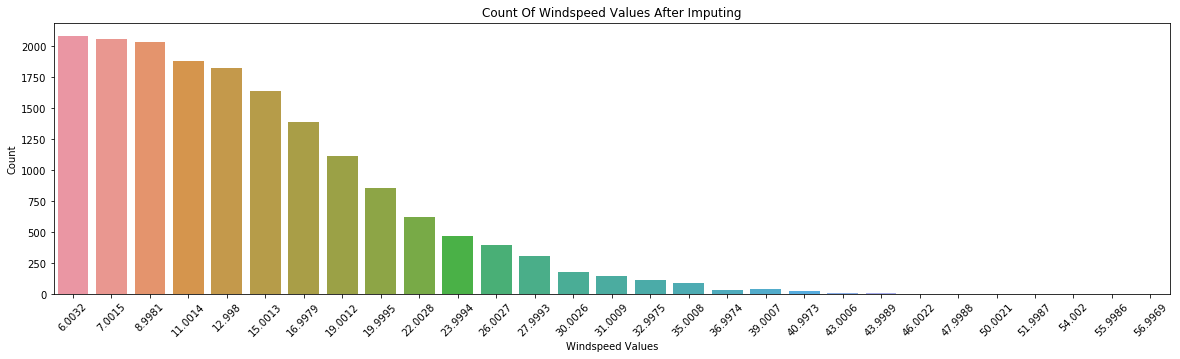

In [9]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sns.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

In [10]:
#Imputing humidity to fill in the zero values
from sklearn.ensemble import RandomForestClassifier

humidityColumns = ["season","weather","windspeed","month","temp","year","atemp"]
datahumidity0 = data[data["humidity"]==0]
datahumidityNot0 = data[data["humidity"]!=0]
datahumidityNot0["humidity"] = datahumidityNot0["humidity"].astype("str")

rf_Model_humidity = RandomForestClassifier()
rf_Model_humidity.fit(datahumidityNot0[humidityColumns], datahumidityNot0["humidity"])
humidity0Values = rf_Model_humidity.predict(X= datahumidity0[humidityColumns])

datahumidity0["humidity"] = humidity0Values
data = datahumidityNot0.append(datahumidity0)
data["humidity"] = data["humidity"].astype("float")

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


 None]

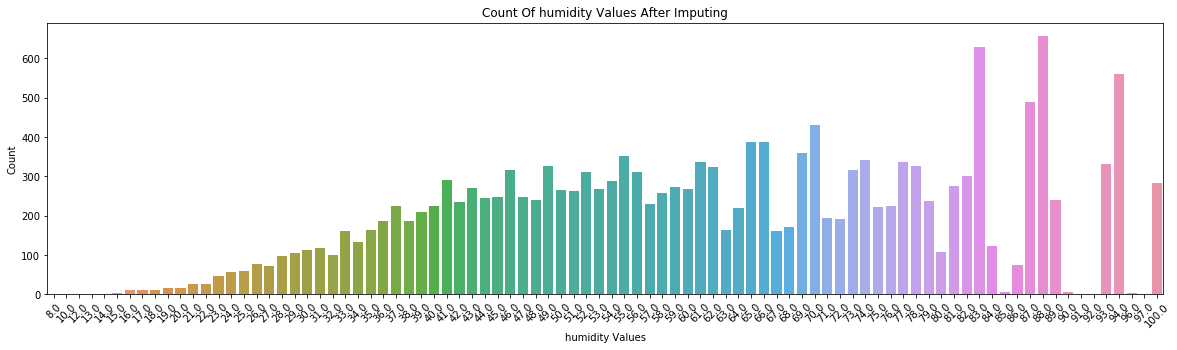

In [11]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
humidity = pd.DataFrame(data.humidity.value_counts()).reset_index()
plt.xticks(rotation=45) 
sns.barplot(data=humidity,x="index",y="humidity",ax=ax)
ax.set(xlabel='humidity Values', ylabel='Count',title="Count Of humidity Values After Imputing",label='big')

In [12]:
#check to make sure that the imputation transfered the dataframe
result = data.apply(pd.value_counts).fillna(0)
print result.head()

       atemp  casual  count  holiday  humidity  registered  season  temp  \
0.000    2.0   986.0    0.0  16879.0       0.0        15.0     0.0   0.0   
0.760    4.0     0.0    0.0      0.0       0.0         0.0     0.0   0.0   
0.820    0.0     0.0    0.0      0.0       0.0         0.0     0.0  17.0   
1.000    0.0   667.0  105.0    500.0       0.0       135.0  4242.0   0.0   
1.515    8.0     0.0    0.0      0.0       0.0         0.0     0.0   0.0   

       weather  windspeed  workingday  year   hour  dayofweek   month    day  \
0.000      0.0        0.0      5514.0   0.0  726.0     2479.0     0.0    0.0   
0.760      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   
0.820      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   
1.000  11413.0        0.0     11865.0   0.0  724.0     2453.0  1429.0  575.0   
1.515      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   

       dayofyear  weekend  day_type  
0.000        0.0  12365.

In [13]:
#split the data into df_train and df_test by day of the month
df_train = data.loc[data['day'] < 20]
df_test = data.loc[data['day'] > 19]
#delete the count,causal,registered columns from the test data after splitting
df_test.drop(['casual','registered','count'], axis=1, inplace=True)

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Casual, Registered, and Count Logrithm

The casual, registered, and count dependent variables are highly skewed.  We can take the logs of each of the variables and use them to obtain more accurate modeling and prediction.  The values are transformed back by taking their exponential.  The plots below show that for each of the dependent variables taking the log gives a more uniform distribution.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.87626461,
          6.87832647,  6.88550967])),
 (1.3647396459244172, 4.5913636904540267, 0.96117937801269571))

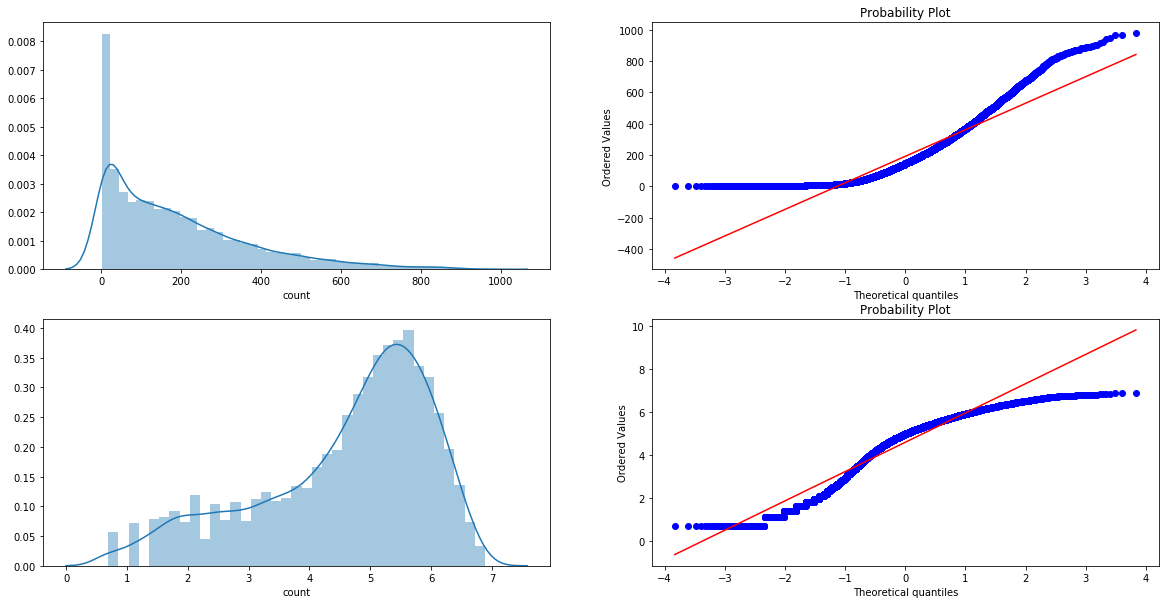

In [14]:
#log of count
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["count"],ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["count"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["count"]), dist='norm', fit=True, plot=axes[1][1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ...,  5.89164421,
          5.89440283,  5.90808294])),
 (1.4665476515913096, 2.7124391746089027, 0.98328305434919172))

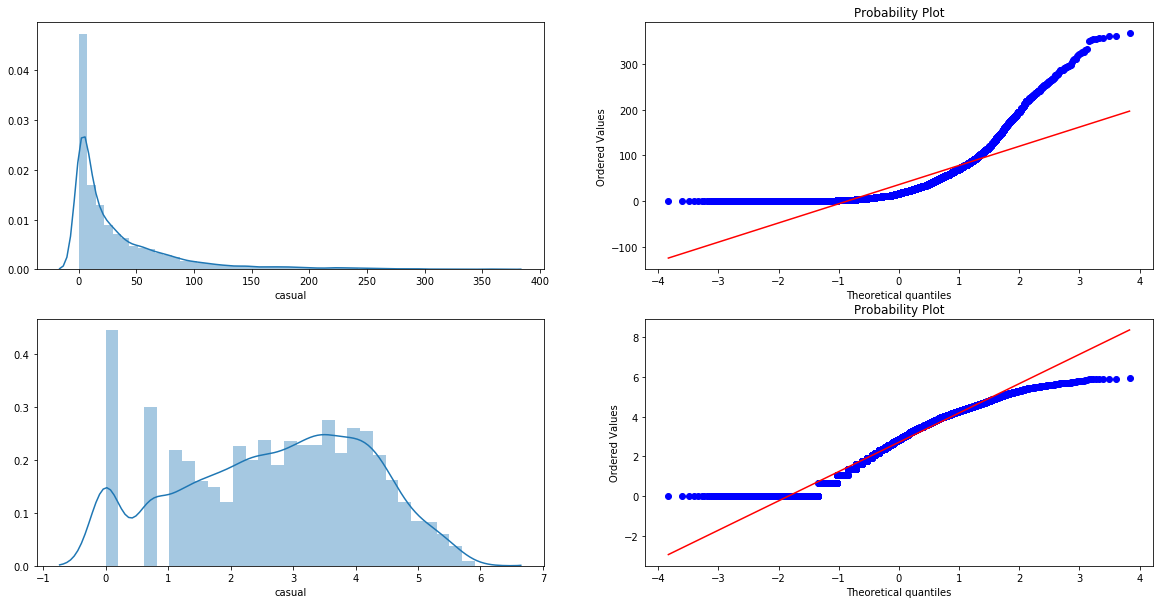

In [15]:
#log of casual
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["casual"],ax=axes[0][0])
stats.probplot(df_train["casual"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["casual"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["casual"]), dist='norm', fit=True, plot=axes[1][1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ...,  6.7546041 ,
          6.7546041 ,  6.78784498])),
 (1.3467198831590608, 4.3957742598456111, 0.96209205209993787))

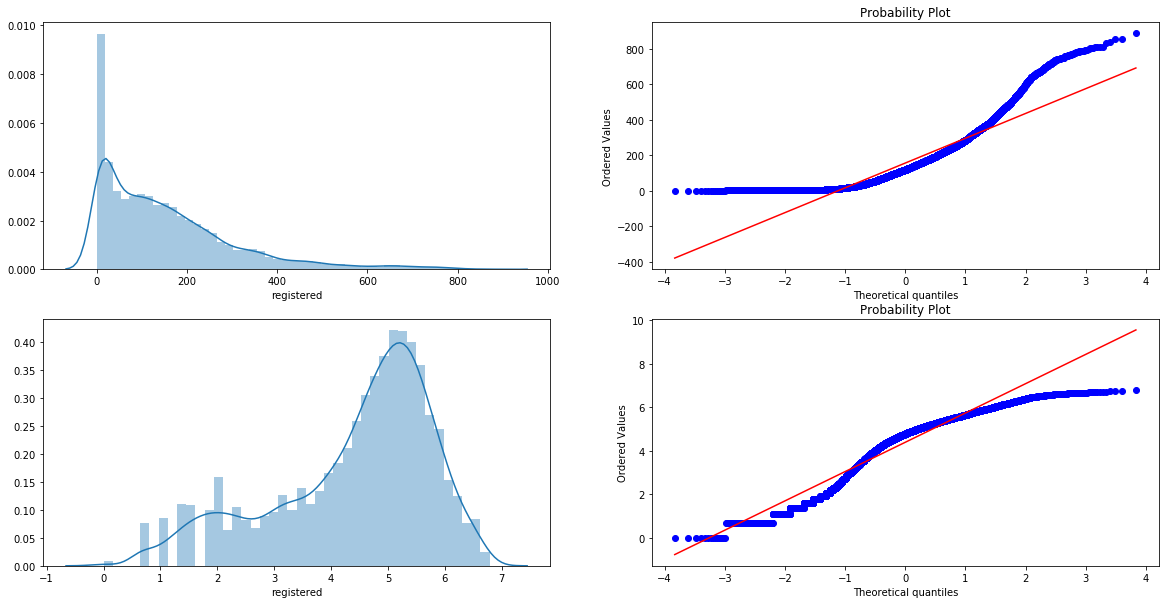

In [16]:
#log of registered
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["registered"],ax=axes[0][0])
stats.probplot(df_train["registered"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["registered"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["registered"]), dist='norm', fit=True, plot=axes[1][1])

In [17]:
#Log Transform dependent variables and add to train dataset
df_train['log_casual'] = np.log1p(df_train['casual'])
df_train['log_registered'] = np.log1p(df_train['registered'])
df_train['log_count'] = np.log1p(df_train['count'])

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [18]:
#verify the log columns added to the train dataset
df_train.shape

(10886, 22)

In [19]:
# get all the features including the new ones created for modeling
features_to_exclude = ['casual', 'registered', 'count', 'log_casual', 'log_registered', 'log_count']
features = [feature for feature in df_train.columns.values if feature not in features_to_exclude]
print features

['atemp', 'holiday', 'humidity', 'season', 'temp', 'weather', 'windspeed', 'workingday', 'year', 'hour', 'dayofweek', 'month', 'day', 'dayofyear', 'weekend', 'day_type']


In [20]:
#Feature Engineered prediction using median model
FE_median_model = DummyRegressor(strategy="median")
FE_median_preds = cross_val_predict(FE_median_model, df_train[features], df_train['count'], cv=10)

kaggle_fit_FE_median = FE_median_model.fit(df_train[features], df_train['count'])
kaggle_predict_FE_median = FE_median_model.predict(df_test[features])

FE_median_RMSLE = RMSLE(df_train['count'], FE_median_preds)
FE_median_R2 = metrics.r2_score(df_train['count'], FE_median_preds)

print 'FE median RMSLE: ', FE_median_RMSLE
print 'FE median R2: ', FE_median_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_predict_FE_median}, columns = ["datetime", "count"])
df_submission.to_csv('FE_median_bike_sharing_prediction_output.csv', index=False)

FE median RMSLE:  1.48734214938
FE median R2:  -0.0976122992241


In [23]:
#Linear regression model
FE_LR_model = LinearRegression()
FE_LR_preds = cross_val_predict(FE_LR_model, df_train[features], df_train['count'], cv=10)
FE_LR_preds[FE_LR_preds<0] = 0

kaggle_LR_fit = FE_LR_model.fit(df_train[features], df_train['count'])
kaggle_LR_predict = FE_LR_model.predict(df_test[features])
kaggle_LR_predict[kaggle_LR_predict<0] = 0

FE_LR_RMSLE = RMSLE(df_train['count'], FE_LR_preds)
FE_LR_R2 = metrics.r2_score(df_train['count'], FE_LR_preds)

print 'FE linear regression RMSLE: ', FE_LR_RMSLE
print 'FE linear regression R2: ', FE_LR_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict}, columns = ["datetime", "count"])
df_submission.to_csv('FE_LR_bike_sharing_prediction_output.csv', index=False)

FE linear regression RMSLE:  1.32169856707
FE linear regression R2:  0.381945582264


In [24]:
#Linear regression model using log_count
FE_LR_model_log = LinearRegression()
FE_LR_preds_log = np.expm1(cross_val_predict(FE_LR_model_log, df_train[features], df_train['log_count'], cv=10))

kaggle_LR_fit_log = FE_LR_model_log.fit(df_train[features], df_train['log_count'])
kaggle_LR_predict_log = np.expm1(FE_LR_model_log.predict(df_test[features]))

FE_LR_RMSLE_log = RMSLE(df_train['count'], FE_LR_preds_log)
FE_LR_R2_log = metrics.r2_score(df_train['count'], FE_LR_preds_log)

print 'FE log_count linear regression RMSLE: ', FE_LR_RMSLE_log
print 'FE log_count linear regression R2: ', FE_LR_R2_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('FE_logcount_LR_bike_sharing_prediction_output.csv', index=False)

FE log_count linear regression RMSLE:  1.02190952052
FE log_count linear regression R2:  0.193678773661


From the above modeling there is a small improvement of 0.001 accuracy using the FE median model, however the linear regression 0.14 improvement in accuracy and then the using the log_count shows another improvement of 0.3 in accuracy.

### Hour, Temperature, and Month Features

The hour, temperature, and month features may be further binned to create new features that will possibly add accuracy to our modeling.

In [25]:
# Put the train and test dataset togeather to create new features
data = df_train.append(df_test)
data.shape

(17379, 22)

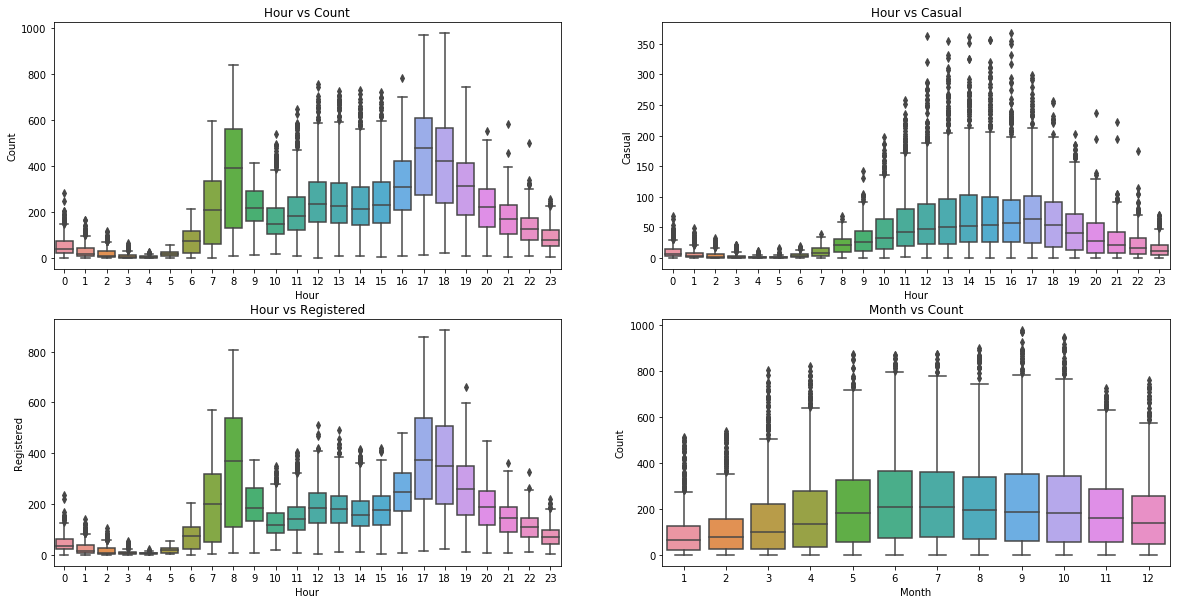

In [26]:
# Plotting the hour and month feature to decide how to bin it
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sns.boxplot(data=data,y="count",x="hour",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="casual",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="registered",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="count",x="month",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Hour', ylabel='Count',title="Hour vs Count")
axes[0][1].set(xlabel='Hour', ylabel='Casual',title="Hour vs Casual")
axes[1][0].set(xlabel='Hour', ylabel='Registered',title="Hour vs Registered")
axes[1][1].set(xlabel='Month', ylabel='Count',title="Month vs Count")

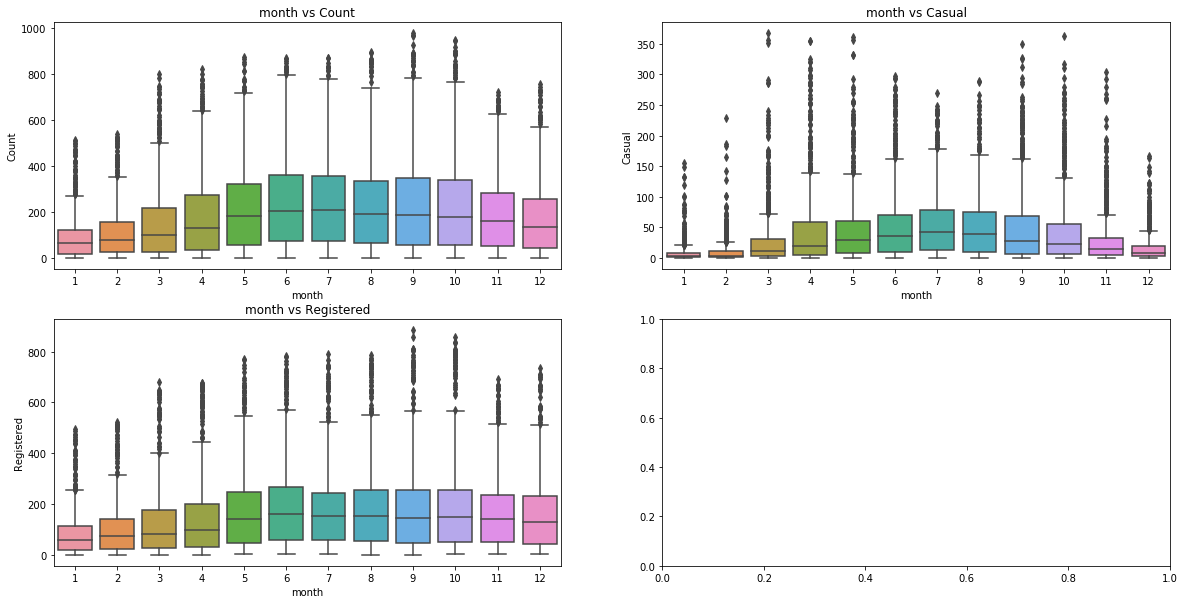

In [27]:
# Plotting the month for casual, registered, and count to decide if need to use casual and registered for seperate binning and feature creation
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sns.boxplot(data=data,y="count",x="month",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="casual",x="month",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="registered",x="month",orient="v",ax=axes[1][0])
#sns.boxplot(data=df_train,y="count",x="dayofyear",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='month', ylabel='Count',title="month vs Count")
axes[0][1].set(xlabel='month', ylabel='Casual',title="month vs Casual")
axes[1][0].set(xlabel='month', ylabel='Registered',title="month vs Registered")
#axes[1][1].set(xlabel='Day of the Year', ylabel='Count',title="Day of the Year vs Count")

In [28]:
#creating extra features for month and hour from the casual and registered variables
data['hour_reg'] = 0
data['hour_cas'] = 0
data['month_part'] = 0
data['hour_reg'] = np.where((data['hour'] < 7) | (data['hour'] > 21), 1, np.where((data['hour'] == 8) | (data['hour'] == 17) | (data['hour'] == 18), 2, 3 ))
data['hour_cas'] = np.where((data['hour'] < 7), 1, np.where(((data['hour'] > 6) & (data['hour'] < 11)) | ((data['hour'] < 24) & (data['hour'] > 10)), 2, 3 ))
data['month_part'] = np.where((data['month'] < 3), 1, np.where(((data['month'] > 2) & (data['month'] < 5)) | ((data['hour'] > 11)), 2, 3 ))
data.head()

,atemp,casual,count,day,day_type,dayofweek,dayofyear,holiday,hour,humidity,...,season,temp,weather,weekend,windspeed,workingday,year,hour_reg,hour_cas,month_part
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 05:00:00,12.880,0.0,1.0,1,0,5,1,0,5,75.0,...,1,9.84,2,1,6.0032,0,2011,1,1,1
2011-01-01 10:00:00,19.695,12.0,36.0,1,0,5,1,0,10,76.0,...,1,15.58,1,1,16.9979,0,2011,3,2,1
2011-01-01 11:00:00,16.665,26.0,56.0,1,0,5,1,0,11,81.0,...,1,14.76,1,1,19.0012,0,2011,3,2,1
2011-01-01 12:00:00,21.210,29.0,84.0,1,0,5,1,0,12,77.0,...,1,17.22,1,1,19.0012,0,2011,3,2,1
2011-01-01 13:00:00,22.725,47.0,94.0,1,0,5,1,0,13,72.0,...,1,18.86,2,1,19.9995,0,2011,3,2,1


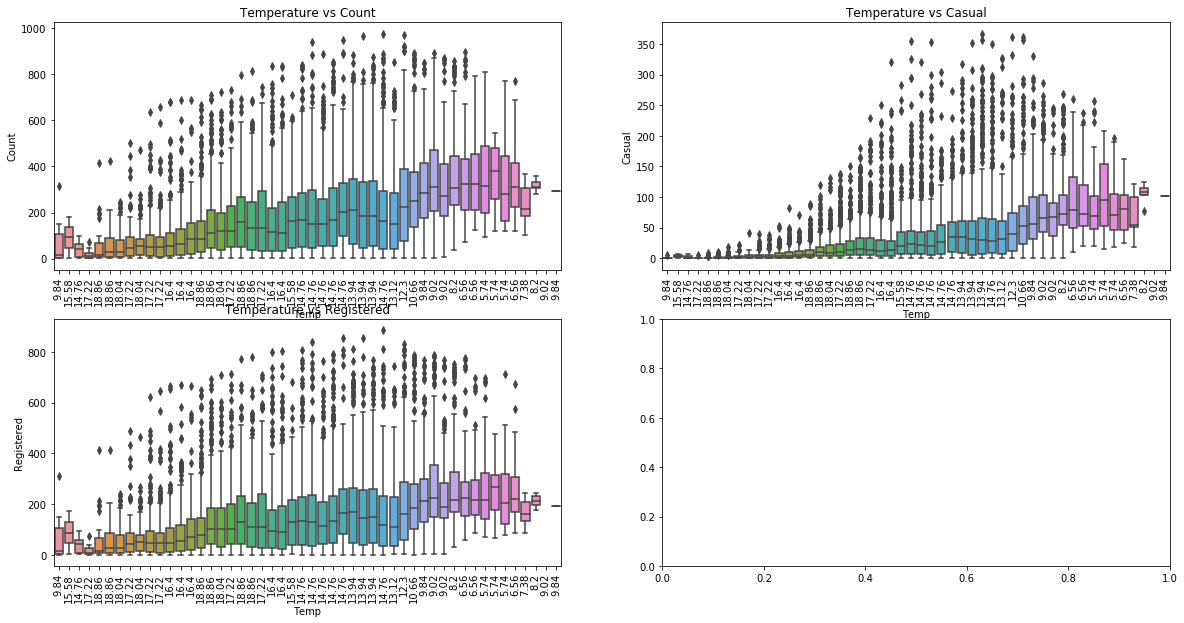

In [29]:
# Plotting temperature for casual, registered, and count to determine if need seperate features
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
a = sns.boxplot(data=data,y="count",x="temp",orient="v",ax=axes[0][0])
b = sns.boxplot(data=data,y="casual",x="temp",orient="v",ax=axes[0][1])
c = sns.boxplot(data=data,y="registered",x="temp",orient="v",ax=axes[1][0])
a.set_xticklabels(data['temp'], rotation = 90)
b.set_xticklabels(data['temp'], rotation = 90)
c.set_xticklabels(data['temp'], rotation = 90)
#sns.boxplot(data=df_train,y="count",x="dayofyear",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Temp', ylabel='Count',title="Temperature vs Count")
axes[0][1].set(xlabel='Temp', ylabel='Casual',title="Temperature vs Casual")
axes[1][0].set(xlabel='Temp', ylabel='Registered',title="Temperature vs Registered")
#axes[1][1].set(xlabel='Day of the Year', ylabel='Count',title="Day of the Year vs Count")

In [30]:
# creating new features for temp based on dependent variables casual and registered and checking all new features are present
data['temp_reg'] = 0
data['temp_part'] = 0
data['temp_reg'] = np.where((data['temp'] < 14.0), 1, np.where((data['temp'] >= 14) & (data['temp'] <= 27), 2, 3 ))
data['temp_part'] = np.where((data['temp'] < 14.0), 1, np.where((data['temp'] >= 14) & (data['temp'] <= 27), 2, 3 ))
data.head()

,atemp,casual,count,day,day_type,dayofweek,dayofyear,holiday,hour,humidity,...,weather,weekend,windspeed,workingday,year,hour_reg,hour_cas,month_part,temp_reg,temp_part
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 05:00:00,12.880,0.0,1.0,1,0,5,1,0,5,75.0,...,2,1,6.0032,0,2011,1,1,1,1,1
2011-01-01 10:00:00,19.695,12.0,36.0,1,0,5,1,0,10,76.0,...,1,1,16.9979,0,2011,3,2,1,2,2
2011-01-01 11:00:00,16.665,26.0,56.0,1,0,5,1,0,11,81.0,...,1,1,19.0012,0,2011,3,2,1,2,2
2011-01-01 12:00:00,21.210,29.0,84.0,1,0,5,1,0,12,77.0,...,1,1,19.0012,0,2011,3,2,1,2,2
2011-01-01 13:00:00,22.725,47.0,94.0,1,0,5,1,0,13,72.0,...,2,1,19.9995,0,2011,3,2,1,2,2


## Model Fitting and Tuning
### Linear Regression
Our feature engineering is now complete and we are moving on to testing different models.  We will start with the linear regression model to verify that our most recent feature engineering has improved the accuracy of our modeling. 

In [31]:
#split the data into df_train and df_test by day of the month and check that shape of the data is correct
df_train = data.loc[data['day'] < 20]
df_test = data.loc[data['day'] > 19]
print df_train.shape
#delete the count,causal,registered columns from the test data after splitting
#print df_test
df_test.drop(['casual','registered','count','log_casual','log_registered','log_count'], axis=1, inplace=True)
print df_test.shape
#print df_test

(10886, 27)
(6493, 21)


/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [32]:
# Set new features
features_to_exclude = ['casual', 'registered', 'count', 'log_casual', 'log_registered', 'log_count']
features = [feature for feature in df_train.columns.values if feature not in features_to_exclude]
print features

['atemp', 'day', 'day_type', 'dayofweek', 'dayofyear', 'holiday', 'hour', 'humidity', 'month', 'season', 'temp', 'weather', 'weekend', 'windspeed', 'workingday', 'year', 'hour_reg', 'hour_cas', 'month_part', 'temp_reg', 'temp_part']


In [33]:
#linear regression model with log count verifying new features helped
FE_LR_model_log = LinearRegression()
FE_LR_preds_log = np.expm1(cross_val_predict(FE_LR_model_log, df_train[features], df_train['log_count'], cv=10))

kaggle_LR_fit_log = FE_LR_model_log.fit(df_train[features], df_train['log_count'])
kaggle_LR_predict_log = np.expm1(FE_LR_model_log.predict(df_test[features]))

FE_bin_LR_RMSLE_log = RMSLE(df_train['count'], FE_LR_preds_log)
FE_bin_LR_R2_log = metrics.r2_score(df_train['count'], FE_LR_preds_log)

print 'FE linear regression RMSLE: ', FE_bin_LR_RMSLE_log
print 'FE linear regression R2: ', FE_bin_LR_R2_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('FE_LR_log_final_bike_sharing_prediction_output.csv', index=False)

FE linear regression RMSLE:  0.772953434118
FE linear regression R2:  0.469794746481


Using our new features we have improved the linear regression model by 0.25 accuracy. 

### Multinode Naive Bayes 
Next we will try a Multinomial Naive Bayes model.

In [34]:
# multinode naive bayes model
MB_model_log = MultinomialNB()
MB_preds_log = np.expm1(cross_val_predict(MB_model_log, df_train[features], df_train['log_count'].astype('int'),cv=10))

kaggle_MB_fit_log = MB_model_log.fit(df_train[features], df_train['log_count'].astype('int'))
kaggle_MB_predict_log = np.expm1(MB_model_log.predict(df_test[features]))

MB_RMSLE_log = RMSLE(df_train['count'], MB_preds_log)
MB_R2_log = metrics.r2_score(df_train['count'], MB_preds_log)

print 'FE MNB RMSLE: ', MB_RMSLE_log
print 'FE MNB R2: ', MB_R2_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('MB_log_final_bike_sharing_prediction_output.csv', index=False)

FE MNB RMSLE:  2.50136181096
FE MNB R2:  -0.182057680359


This model performed very poorly for this data, with the accuracy decreasing.

### k-Nearest Neighbors
Next we will try a k-Nearest Neighbors model.

In [35]:
# kNN model
k = 10
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = k, weights = "distance"))
knn_preds = np.expm1(cross_val_predict(knn_pipe, df_train[features], df_train['log_count'], cv=10))

kNN_RMSLE_log = RMSLE(df_train['count'], knn_preds)
kNN_R2_log = metrics.r2_score(df_train['count'], knn_preds)

print 'kNN RMSLE: ', kNN_RMSLE_log
print 'kNN R2: ', kNN_R2_log

kaggle_knn_fit_log = knn_pipe.fit(df_train[features], df_train['log_count'])
kaggle_knn_predict_log = np.expm1(knn_pipe.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_knn_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('knn_bike_sharing_prediction_output.csv', index=False)

kNN RMSLE:  0.725548491584
kNN R2:  0.686552265041


The accuracy was improved by 0.044 with k-Nearest Neighbor model.

### Decision Trees
Next we try a decision trees model.

In [36]:
# Decision Tree modeling
dt_model_log = DecisionTreeRegressor(max_depth=10)
dt_preds_log = np.expm1(cross_val_predict(dt_model_log, df_train[features], df_train['log_count'], cv=10))

dt_RMSLE_log = RMSLE(df_train['count'], dt_preds_log)
dt_R2_log = metrics.r2_score(df_train['count'], dt_preds_log)

print 'DT RMSLE: ', dt_RMSLE_log
print 'DT R2: ', dt_R2_log

kaggle_dt_fit_log = dt_model_log.fit(df_train[features], df_train['log_count'])
kaggle_dt_predict_log = np.expm1(dt_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_dt_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('dt_bike_sharing_prediction_output.csv', index=False)

DT RMSLE:  0.492954540412
DT R2:  0.804120791053


The accuracy was improved by 0.24 with decision tress regression.

### Random Forest
Next we try a Random Forest Model.

In [37]:
# Random Forest model
rf_model_log = RandomForestRegressor(n_estimators = 100, max_features = 8, max_depth = 20)
rf_preds_log = np.expm1(cross_val_predict(rf_model_log, df_train[features], df_train['log_count'], cv=10, n_jobs=-1))

rf_RMSLE_log = RMSLE(df_train['count'], rf_preds_log)
rf_R2_log = metrics.r2_score(df_train['count'], rf_preds_log)

print 'RF RMSLE: ', rf_RMSLE_log
print 'RF R2: ', rf_R2_log

kaggle_rf_fit_log = rf_model_log.fit(df_train[features], df_train['log_count'])
kaggle_rf_predict_log = np.expm1(rf_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_rf_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('rf_bike_sharing_prediction_output.csv', index=False)

RF RMSLE:  0.370600592113
RF R2:  0.901982629425


Random Forest improved the accuracy significantly by 0.12, however we may be able to do slightly better by doing parameter tuning.  

In [38]:
# Random forest paramter tuning using grid search 
rf_params = {'n_estimators': np.arange(1,30), 
             'max_features': [8],
             'max_depth': [10, 20, 30, 40, 50]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring='mean_squared_error', cv=10)
rf_grid.fit(df_train[features], df_train['log_count'])
print (np.sqrt(-rf_grid.best_score_))
print (rf_grid.best_params_)

0.405774298264
{'max_features': 8, 'n_estimators': 26, 'max_depth': 50}


The number of estimators seems to significantly affect the RMSLE, below we run the parameter tuning again with a larger range of estimators. 

In [245]:
# Random forest paramter tuning using grid search 
rf_params = {'n_estimators': np.arange(100,500,100), 
             'max_features': [8],
             'max_depth': [10]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring='mean_squared_error', cv=10)
rf_grid.fit(df_train[features], df_train['log_count'])
print (np.sqrt(-rf_grid.best_score_))
print (rf_grid.best_params_)

0.440463848045
{'max_features': 8, 'n_estimators': 400, 'max_depth': 10}


Running random forest model again with n_estimators = 400.

In [39]:
# Random Forest model tuned
rf_model_log = RandomForestRegressor(n_estimators = 400, max_features = 8, max_depth = 40)
rf_preds_log = np.expm1(cross_val_predict(rf_model_log, df_train[features], df_train['log_count'], cv=10, n_jobs=-1))

rf_tune_RMSLE_log = RMSLE(df_train['count'], rf_preds_log)
rf_tune_R2_log = metrics.r2_score(df_train['count'], rf_preds_log)

print 'RF RMSLE: ', rf_tune_RMSLE_log
print 'RF R2: ', rf_tune_R2_log

kaggle_rf_fit_log = rf_model_log.fit(df_train[features], df_train['log_count'])
kaggle_rf_predict_log = np.expm1(rf_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_rf_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('rf_tuned_bike_sharing_prediction_output.csv', index=False)

RF RMSLE:  0.369150901583
RF R2:  0.900958697004


We can see that increasing the number of estimators will decrease the RMSLE and improve accuracy, though it takes a much more time and computation resources so there is a tradeoff.  The plots below show that the gain from the number of estimators plateaus around 20 and the maximum depth around 40.

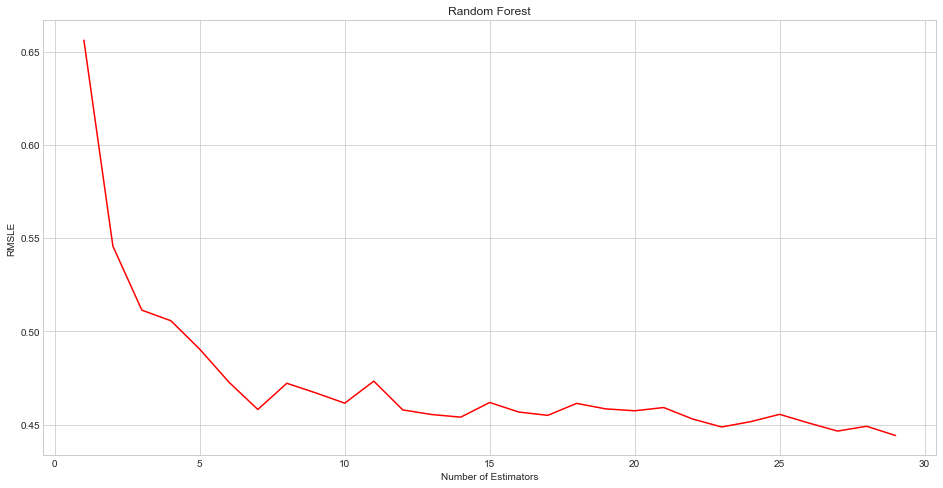

In [40]:
# Random forest plot
sns.set_style("whitegrid")
accuracies = [np.sqrt(-(rf_grid.grid_scores_[i][1])) for i in range(29)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["n_estimators"], accuracies, 'r')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Number of Estimators")
ylabel = plt.ylabel ("RMSLE")

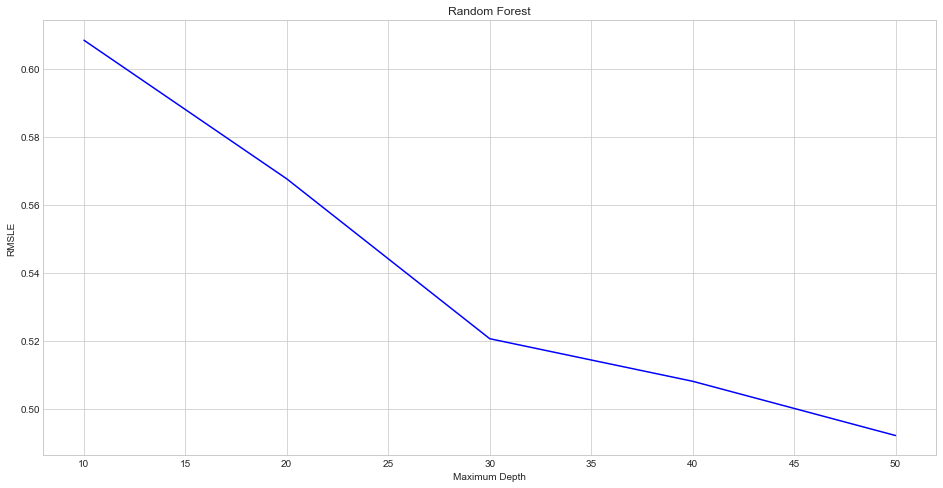

In [239]:
# Random forest plot
sns.set_style("whitegrid")
accuracies = [np.sqrt(-(rf_grid.grid_scores_[i][1])) for i in range(5)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["max_depth"], accuracies, 'b')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Maximum Depth")
ylabel = plt.ylabel ("RMSLE")

### Gradient Boost
Next we will try gradient boosting modeling.  

In [41]:
# gradient boosting modeling
gb_model_log = GradientBoostingRegressor(learning_rate=0.05, max_depth=40, min_samples_leaf=27)
gb_preds_log = np.expm1(cross_val_predict(gb_model_log, df_train[features], df_train['log_count'], cv=10))

gb_RMSLE_log = RMSLE(df_train['count'], gb_preds_log)
gb_R2_log = metrics.r2_score(df_train['count'], gb_preds_log)

print 'GB RMSLE: ', gb_RMSLE_log
print 'GB R2: ', gb_R2_log

kaggle_gb_fit_log = gb_model_log.fit(df_train[features], df_train['log_count'])
kaggle_gb_predict_log = np.expm1(gb_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_gb_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('gb_bike_sharing_prediction_output.csv', index=False)

GB RMSLE:  0.332560087524
GB R2:  0.921074188131


The gradient boosting model increased the accuracy by 0.03.

### Predicting casual and registered users separately
As seen from the scatterplot matrix above, casual and registered bike users behave quite differently. We can take advantage of the split that is provided in the data. We can fit two different models to each group of users, then add them up. Doing so should improve the performance of a standalone model.

In [42]:
np.random.seed(0)

# Casual
casual_model = GradientBoostingRegressor(learning_rate=0.05, max_features=10, max_depth=40, min_samples_leaf=27)
preds_casual = np.expm1(cross_val_predict(casual_model, df_train[features], df_train['log_casual'], cv=10, n_jobs=-1))

cgb_RMSLE_log = RMSLE(df_train['casual'], preds_casual)
cgb_R2_log = metrics.r2_score(df_train['casual'], preds_casual)

print 'Casual GB RMSLE: ', cgb_RMSLE_log
print 'Casual GB R2: ', cgb_R2_log

kaggle_casual_fit_log = casual_model.fit(df_train[features], df_train['log_casual'])
kaggle_casual_predict_log = np.expm1(casual_model.predict(df_test[features]))

# Registered
reg_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_features=10, max_depth=40, min_samples_leaf=27)
preds_reg = np.expm1(cross_val_predict(reg_model, df_train[features], df_train['log_registered'], cv=10, n_jobs=-1))

rgb_RMSLE_log = RMSLE(df_train['registered'], preds_reg)
rgb_R2_log = metrics.r2_score(df_train['registered'], preds_reg)

print 'Registered GB RMSLE: ', rgb_RMSLE_log
print 'Registered GB R2: ', rgb_R2_log

kaggle_registered_fit_log = reg_model.fit(df_train[features], df_train['log_count'])
kaggle_registered_predict_log = np.expm1(reg_model.predict(df_test[features]))

#Registered + Casual
preds_total = preds_casual + preds_reg

rcgb_RMSLE_log = RMSLE(df_train['count'], preds_total)
rcgb_R2_log = metrics.r2_score(df_train['count'], preds_total)

print 'Registered + Casual GB RMSLE: ', rcgb_RMSLE_log
print 'Registered + Casual GB R2: ', rcgb_R2_log
#print preds_total.shape

kaggle_count_predict_log = kaggle_registered_predict_log + kaggle_casual_predict_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_gb_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('gbrc_bike_sharing_prediction_output.csv', index=False)

Casual GB RMSLE:  0.509829888842
Casual GB R2:  0.869433915861
Registered GB RMSLE:  0.314104302066
Registered GB R2:  0.940229373079
Registered + Casual GB RMSLE:  0.314737402353
Registered + Casual GB R2:  0.937746277957


Modeling casual and registered separately provided a slight improvement in accuracy of 0.02.

## Error Analysis

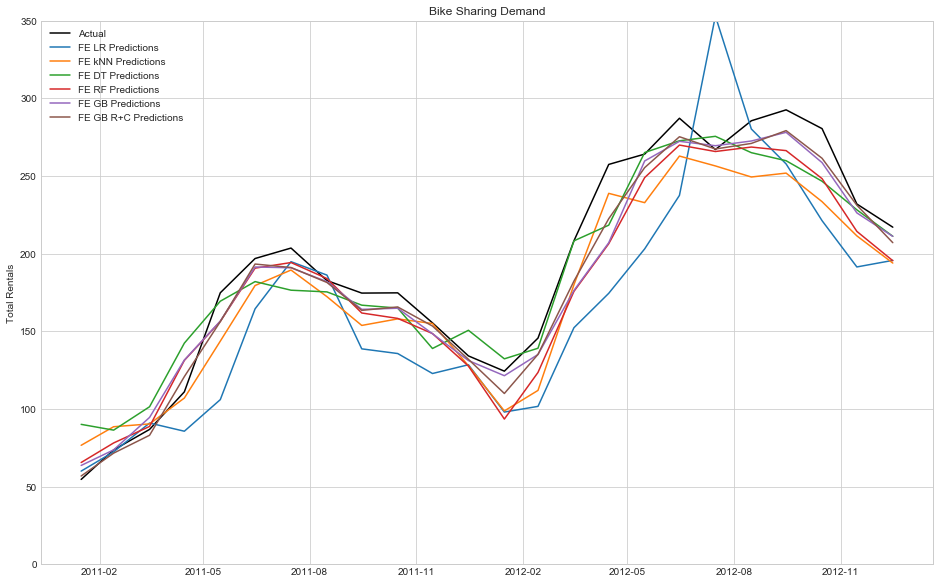

In [67]:
# Compare a monthly mean version of predictions with the actual figures
df_monthlymean = df_train.resample('M').mean()

df_preds_lr = pd.DataFrame({'FE_LR_preds_log':FE_LR_preds_log}, index=df_train.index)
df_preds_lr_monthly = df_preds_lr.resample('M').mean()

df_preds_knn = pd.DataFrame({'knn_preds':knn_preds}, index=df_train.index)
df_preds_knn_monthly = df_preds_knn.resample('M').mean()

df_preds_dt = pd.DataFrame({'dt_preds_log':dt_preds_log}, index=df_train.index)
df_preds_dt_monthly = df_preds_dt.resample('M').mean()

df_preds_rf = pd.DataFrame({'rf_preds_log':rf_preds_log}, index=df_train.index)
df_preds_rf_monthly = df_preds_rf.resample('M').mean()

df_preds_gb = pd.DataFrame({'gb_preds_log':gb_preds_log}, index=df_train.index)
df_preds_gb_monthly = df_preds_gb.resample('M').mean()

df_preds = pd.DataFrame({'preds_total':preds_total}, index=df_train.index)
df_preds_monthly = df_preds.resample('M').mean()

# Plot
plt.figure(figsize = (16,10))
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Actual", color = 'black')
lr_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_lr_monthly['FE_LR_preds_log'], label="FE LR Predictions")
knn_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_knn_monthly['knn_preds'], label="FE kNN Predictions")
dt_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_dt_monthly['dt_preds_log'], label="FE DT Predictions")
rf_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_rf_monthly['rf_preds_log'], label="FE RF Predictions")
gb_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_gb_monthly['gb_preds_log'], label="FE GB Predictions")
gbrc_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_monthly['preds_total'], label="FE GB R+C Predictions")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
yaxis = plt.ylim(0,350)
legend = plt.legend(frameon=False)

## Overall Results
We submitted our FE gradient boosted model that used the registered + causal = count and got a score back of 0.43855, which gave us a rank of 740/3215 = 23%

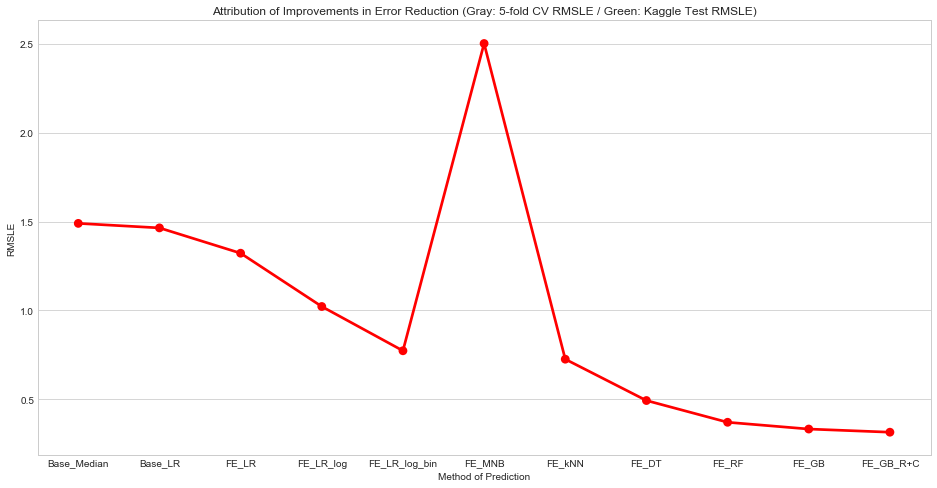

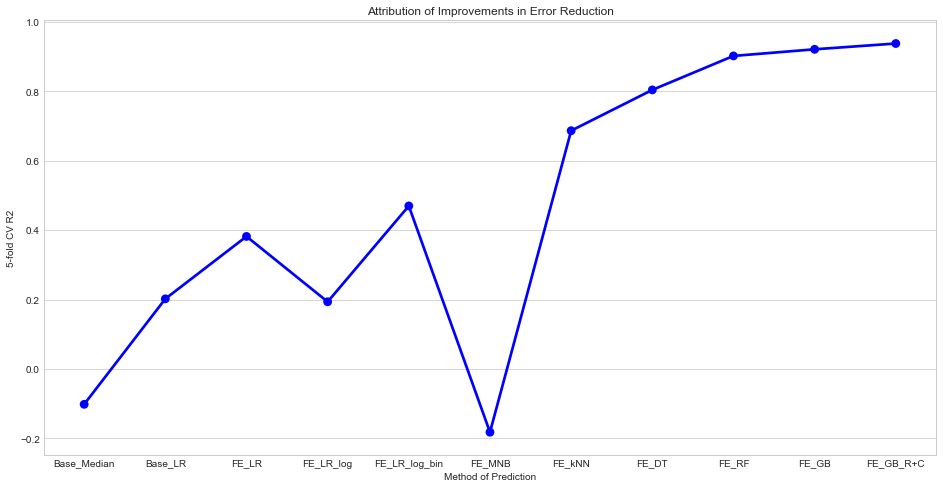

In [52]:
#summary of RMSLE scores and R2 scores
attribution = pd.DataFrame({'model_names': ['Base_Median', 'Base_LR', 'FE_LR', 'FE_LR_log', 'FE_LR_log_bin', 'FE_MNB', 'FE_kNN', 'FE_DT', 'FE_RF', 'FE_GB', 'FE_GB_R+C'],
                            'rmsle': [base_median_RMSLE, base_LR_RMSLE, FE_LR_RMSLE, FE_LR_RMSLE_log, FE_bin_LR_RMSLE_log, MB_RMSLE_log, kNN_RMSLE_log, dt_RMSLE_log, rf_RMSLE_log, gb_RMSLE_log, rcgb_RMSLE_log],
                            'r2': [base_median_R2, base_LR_R2, FE_LR_R2, FE_LR_R2_log, FE_bin_LR_R2_log, MB_R2_log, kNN_R2_log, dt_R2_log, rf_R2_log, gb_R2_log, rcgb_R2_log]})
    
sns.set_style('whitegrid')
# plot RMSLE
plt.figure(figsize=(16,8))
sns.pointplot(x='model_names', y='rmsle', data=attribution, color='r')
title = plt.title('Attribution of Improvements in Error Reduction (Gray: 5-fold CV RMSLE / Green: Kaggle Test RMSLE)')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("RMSLE")
# Plot R2
plt.figure(figsize=(16,8))
sns.pointplot(x='model_names', y='r2', data=attribution, color='b')
title = plt.title('Attribution of Improvements in Error Reduction')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("5-fold CV R2")

## Conclusions
In Conclusion, feature engineering and model tuning were an important part of improving the prediction accuarcy for any given model.  Our feature engineering consisted of creating new features based on the datetime column, imputing windspeed and humidity to fill in missing values, log transforming our depedent variables, and finally creating more new features by binning hour, temperature, and month by casual and registered user.  The linear regression model was used as a baseline to verify our feature engineering was improving our accuracy.  We then evaluated several different models, kNN, multinode naive bayes, decision trees, random forests, and gradient boosting.  Using this process we improved our score from We managed to improve from the mean model error of 1.48 to 0.31, with a final score of 0.43855, which gave us a rank of 740/3215 = 23%

## Future Work
We think that future work should be focused on a few key areas:

- Additional data collection: we could collect addtional data such as pollution, traffic, demographics, etc. to create new features that would improve accuracy of predictions.

- Modeling and tuning: we could investigate more advanced modeling techniques such as deep learning or AI algorithms and if we have more time or computational power can perfect the tuning of our parameters to improve accuracy of predictions.  

- Feature Engineering: Much more could be done with feature engineering, possibly using modeling to bin and select the most important features for predictions.  